In [2]:
import pymongo, os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from collections import OrderedDict

/Users/singhv/Library/Python/2.7/lib/python/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
client = pymongo.MongoClient('localhost', 27017)
db = client["WATSON"]

In [4]:
DESKTOP = os.path.join(os.environ["HOME"], "Desktop")
base_dir = os.path.join(DESKTOP, "trial_stats")
targeted_therapy_trials = [ line.strip() for line in open(os.path.join(base_dir, "targeted_therapy_ncts.txt")) if line != "" ]
existing_trials = [ line.strip() for line in open(os.path.join(base_dir, "existing_trials_wfg.txt")) if line != "" ]
cancer_genes = pd.read_csv(os.path.join(base_dir, "cancer_genes50.txt"),header=None)[0]
cancer_genes = list(cancer_genes)
new_targeted_therapy_trials = set(targeted_therapy_trials).difference(set(existing_trials))

In [39]:
country_counts = dict()
for study in db["CTGOV"].find({"NCT_ID" : {"$in" : targeted_therapy_trials}}):
    for country in set(study["COUNTRIES"]):
        if country in country_counts: 
            country_counts[country].append(study["NCT_ID"])
        else:
            country_counts[country] = [study["NCT_ID"]]
            
country_counts = OrderedDict(sorted(country_counts.items(), key=lambda x: len(x[1]), reverse=True))

In [14]:
print len(country_counts[0][1])

2524


In [5]:
top10_countries = [ x[0] for x in country_counts[:10] ]
top10_count = [ len(x[1]) for x in country_counts[:10] ]
print top10_count

[2524, 562, 515, 464, 461, 460, 391, 386, 377, 273]


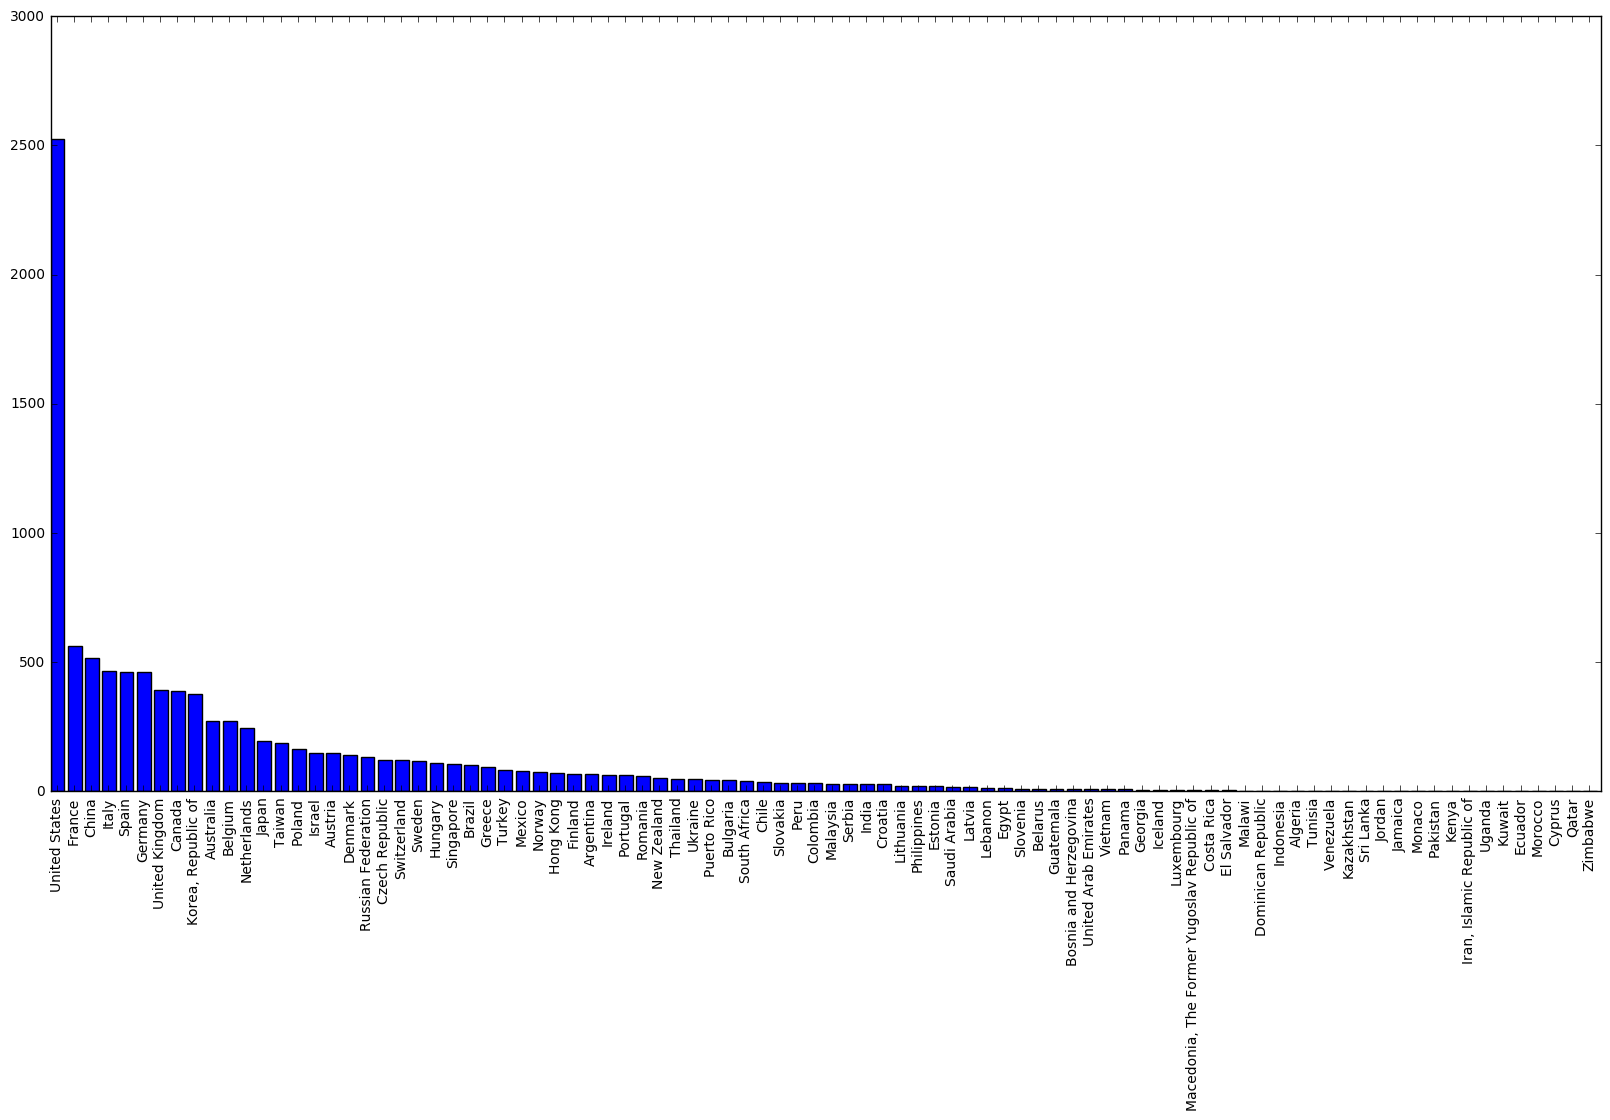

In [42]:
ind = np.arange(len(country_counts))
#print ind
width = 0.35
plt.figure(figsize=(20,10))
rects = plt.bar(ind, [len(x) for x in country_counts.values()])
plt.xticks(ind + width, country_counts.keys(), rotation='vertical')
plt.show()

In [5]:
quest_drugs = pd.read_csv(os.path.join(base_dir, "Drugs_for_Quest_Panel.tsv"), delimiter="\t")
#print quest_drugs["Therapy ID"]
#new_studies = db["CTGOV"].find({"NCT_ID" : {"$in" : list(new_targeted_therapy_trials)}, "COUNTRIES" : "United States"})
new_studies = db["CTGOV"].find({"metadata.STATUS" : "NEW", "STATUS" : {"$ne" : "Terminated"}, "COUNTRIES" : "United States"})
all_drug_to_trial_dicts = []
studies_count_based_on_drug = dict()
for study in new_studies:
    wga_drug_ids = [ intervention.get("WGADB_ID") for intervention in study["interventions"] if "WGADB_ID" in intervention ]          
    temp = [ (wga_drug_id, study["NCT_ID"]) for wga_drug_id in wga_drug_ids ]
    all_drug_to_trial_dicts.extend(temp)
    
#print all_drug_to_trial_dicts[:10]
for (wga_drug_id, nct_id) in all_drug_to_trial_dicts:
    if (quest_drugs["Therapy ID"] == wga_drug_id).any():
        if wga_drug_id in studies_count_based_on_drug:
            studies_count_based_on_drug[wga_drug_id].append(nct_id)
        else:
            studies_count_based_on_drug[wga_drug_id] = [nct_id]

In [9]:
temp = []
[ temp.extend(value) for value in studies_count_based_on_drug.values() ]
print len(set(temp))
with open(os.path.join(base_dir, "all_quest_trial_ids.txt"), "wb") as f:
    [f.write(nct_id + "\n") for nct_id in set(temp)]

486


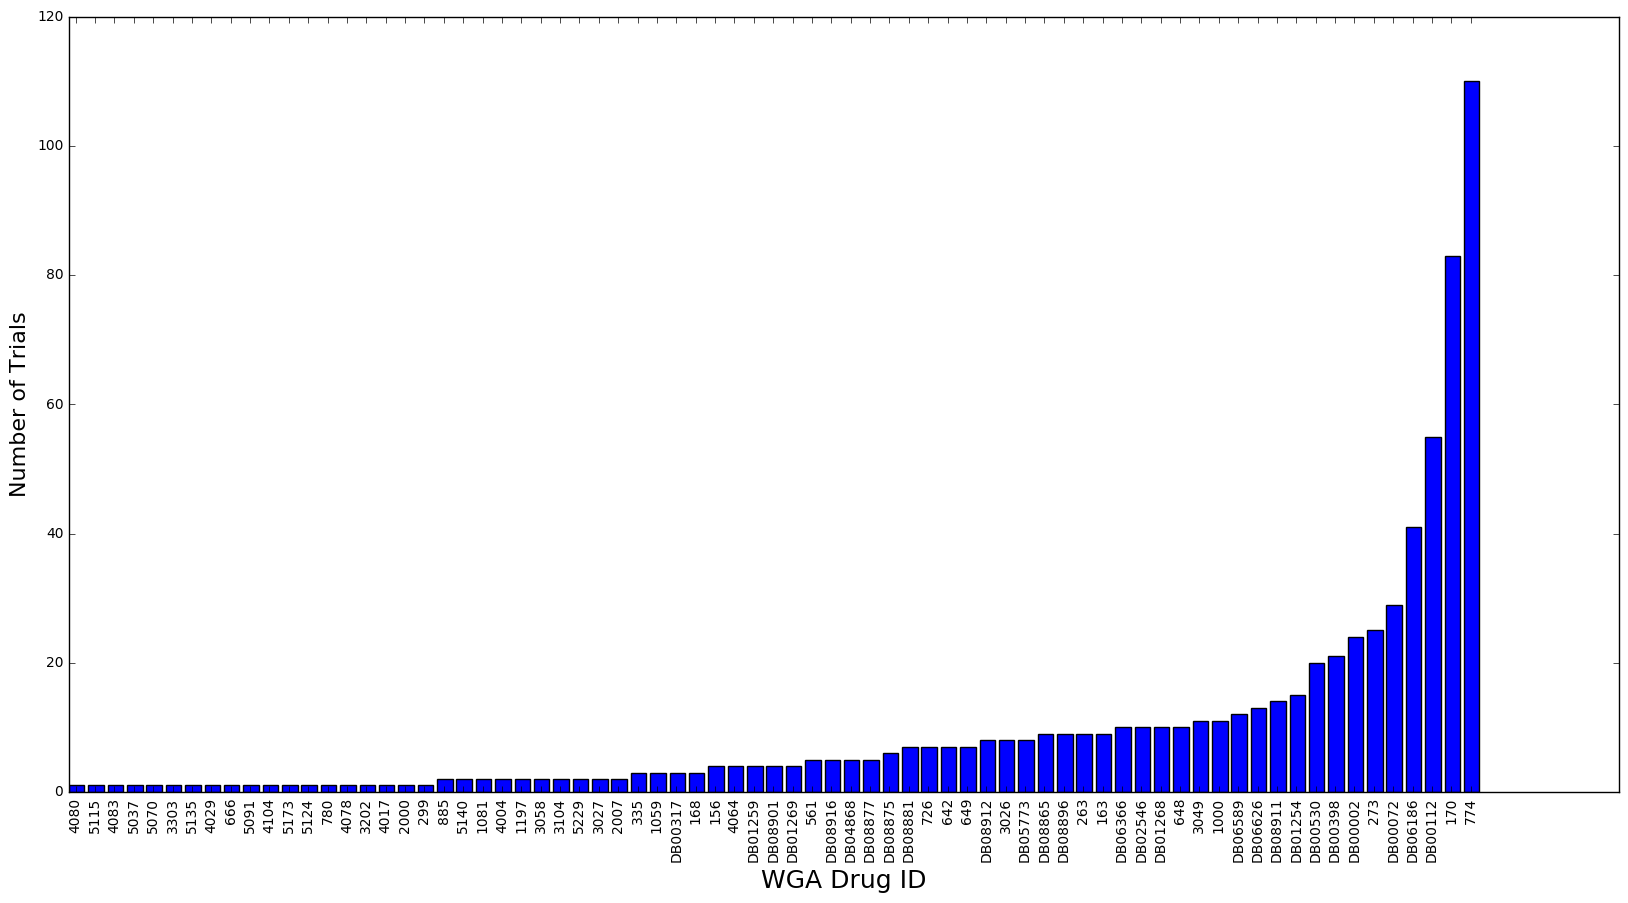

In [6]:
studies_count_based_on_drug = OrderedDict(sorted(studies_count_based_on_drug.items(), key=lambda t: len(t[1])))
ind = np.arange(len(studies_count_based_on_drug))
width = 0.35
plt.figure(figsize=(20,10))
rects = plt.bar(ind, [ len(x) for x in studies_count_based_on_drug.values() ])
plt.xticks(ind + width, studies_count_based_on_drug.keys(), rotation='vertical')
plt.xlabel('WGA Drug ID', fontsize=18)
plt.ylabel('Number of Trials', fontsize=16)
plt.show()

In [7]:
df = pd.DataFrame({"NCT_IDS": [", ".join(nct_ids) for nct_ids in studies_count_based_on_drug.values()]}, index=studies_count_based_on_drug.keys())
print studies_count_based_on_drug.keys()

[u'5115', u'5173', u'4083', u'DB00112', u'885', u'156', u'335', u'5037', u'5140', u'5070', u'3049', u'DB08916', u'273', u'DB08912', u'DB08911', u'DB08875', u'DB08865', u'DB05773', u'3303', u'170', u'DB04868', u'4064', u'DB06186', u'3026', u'1197', u'4029', u'DB06589', u'DB01259', u'561', u'DB01254', u'774', u'DB06366', u'DB00317', u'DB06626', u'DB00072', u'263', u'DB02546', u'DB08901', u'3058', u'648', u'5124', u'DB00398', u'168', u'DB08877', u'163', u'5229', u'4078', u'DB00530', u'DB01268', u'DB01269', u'726', u'3104', u'2000', u'642', u'2007', u'649', u'DB08896', u'DB00002', u'1000']


In [8]:
df.to_csv(os.path.join(base_dir,"quest_drug_trials_v2.tsv"), sep="\t")

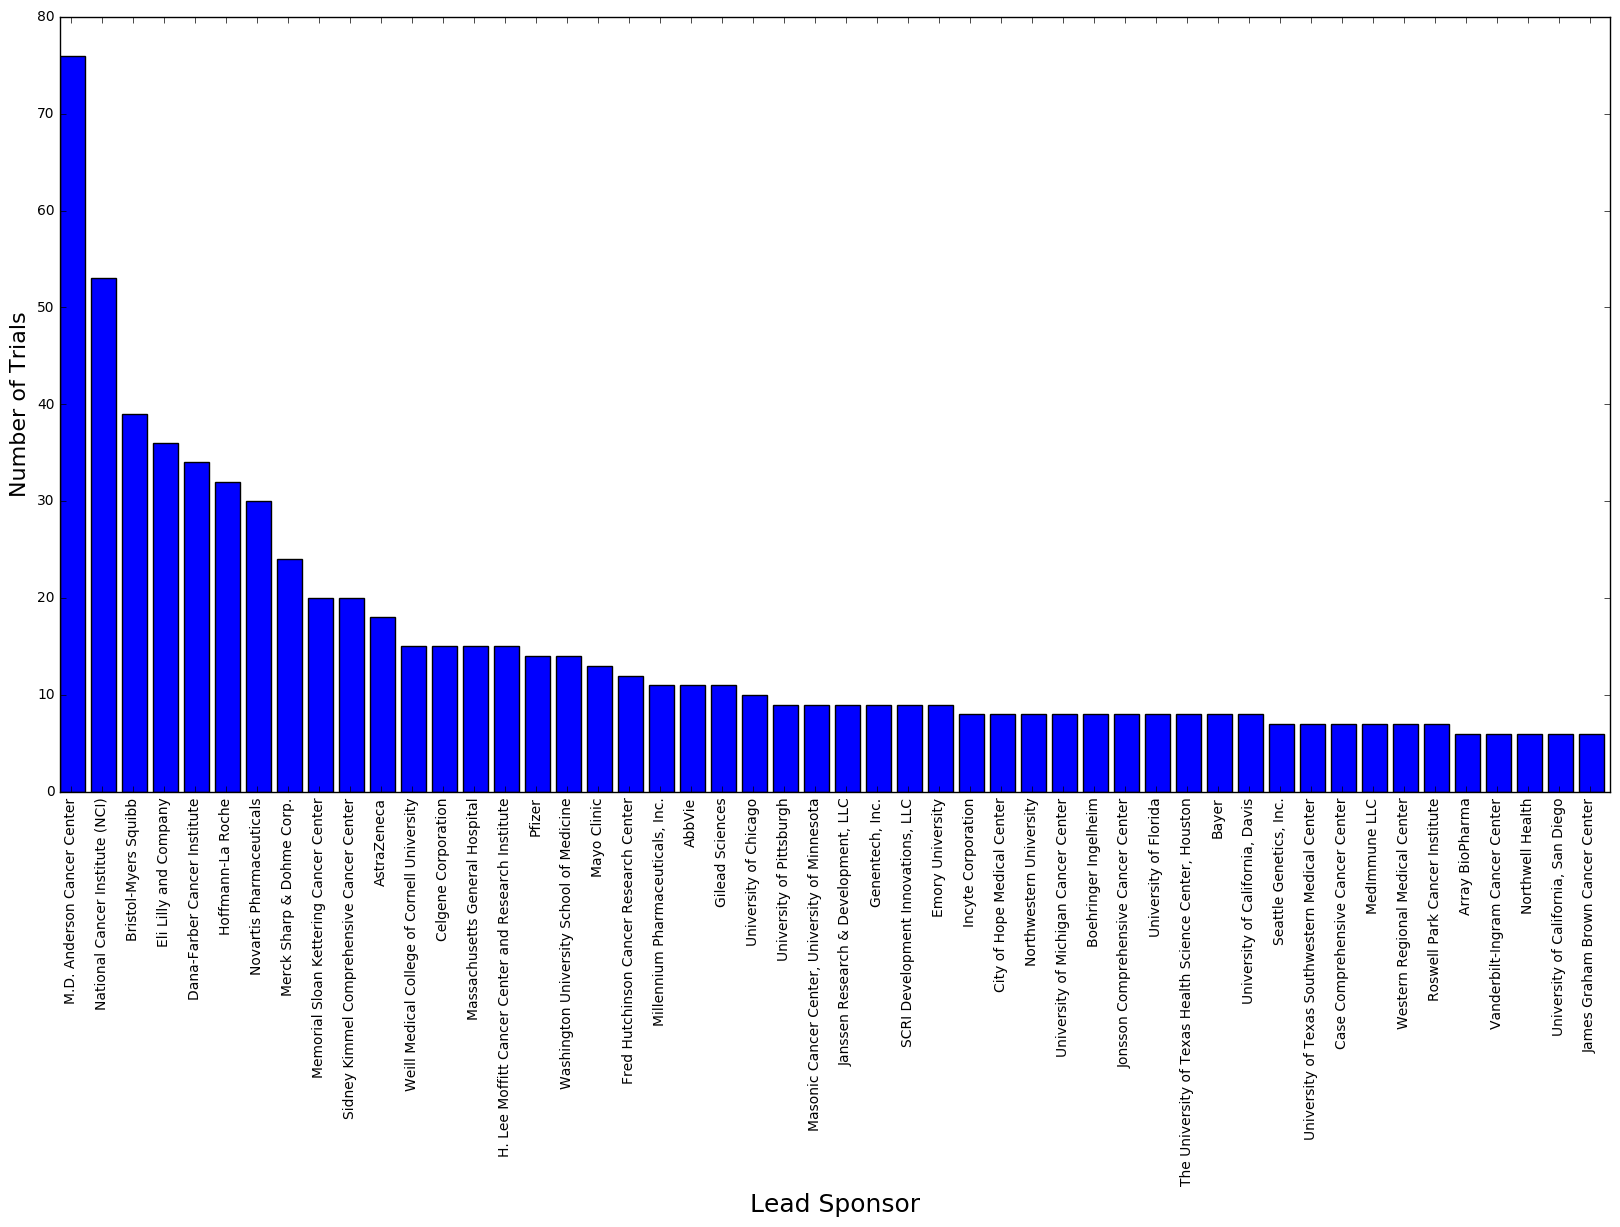

In [38]:
lead_sponsors_dict = dict()
collaborators_dict = dict()
for study in db["CTGOV"].find({"NCT_ID" : {"$in" : list(new_targeted_therapy_trials)}, "COUNTRIES" : "United States"}):
    lead_sponsor = study["leadSponsor"]["AGENCY"]
    lead_sponsors_dict[lead_sponsor] = lead_sponsors_dict.get(lead_sponsor, 0) + 1
    for collaborator in study["collaborators"]:
        collaborators_dict[collaborator["AGENCY"]] = collaborators_dict.get(collaborator["AGENCY"], 0) + 1
        
lead_sponsors_dict = OrderedDict(sorted(lead_sponsors_dict.items(), key=lambda t: t[1], reverse=True))
ind = np.arange(50)
width = 0.35
plt.figure(figsize=(20,10))
rects = plt.bar(ind, lead_sponsors_dict.values()[:50])
plt.xticks(ind + width, lead_sponsors_dict.keys()[:50], rotation='vertical')
plt.xlabel('Lead Sponsor', fontsize=18)
plt.ylabel('Number of Trials', fontsize=16)
plt.show()

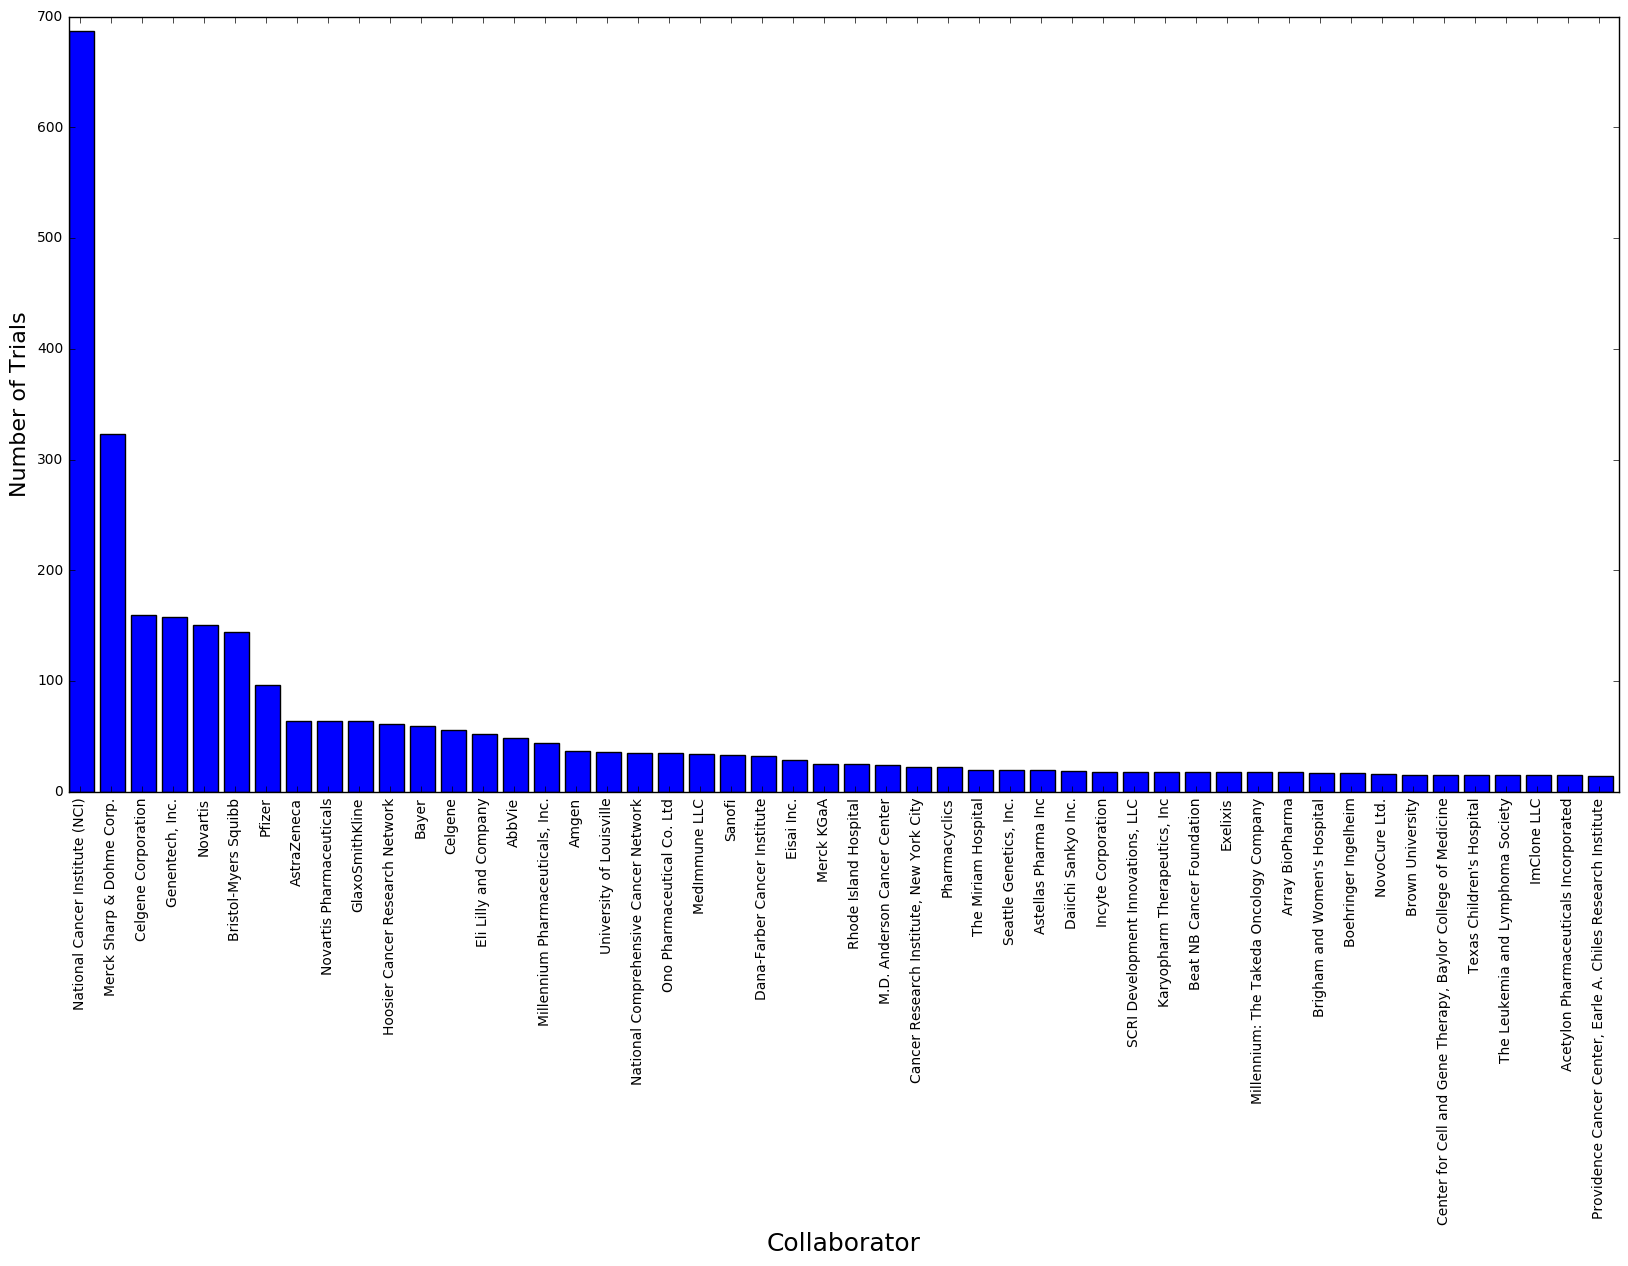

In [44]:
collaborators_dict = OrderedDict(sorted(collaborators_dict.items(), key=lambda t: t[1], reverse=True))
ind = np.arange(50)
width = 0.35
plt.figure(figsize=(20,10))
rects = plt.bar(ind, collaborators_dict.values()[:50])
plt.xticks(ind + width, collaborators_dict.keys()[:50], rotation='vertical')
plt.xlabel('Collaborator', fontsize=18)
plt.ylabel('Number of Trials', fontsize=16)
plt.show()